# Visualization Code for Machine Learning the Warm Rain Process
David John Gagne

This notebook contains the code for generating some of the figures and tables in Machine Learning the Warm Rain Process.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from os.path import join, exists
from matplotlib.colors import LogNorm
from mlmicrophysics.metrics import hellinger_distance, r2_corr, root_mean_squared_error
from sklearn.metrics import mean_absolute_error, confusion_matrix
from tensorflow.keras.models import load_model
import cartopy.crs as ccrs

# Load Output Data
These cells load the prediction and truth data along with previously calculated verification scores.

In [2]:
source = "TAU"
if source == "sd":
    data_path = "/glade/p/cisl/aiml/ggantos/cam_sd_model_base_full_moredata/"
elif source == "TAU":
    data_path = "/glade/p/cisl/aiml/ggantos/cam_run5_models_20190726_noL2/"
else:
    data_path = None

print("load test prediction labels")
test_pred_labels = pd.read_csv(join(data_path, "test_prediction_labels.csv"), index_col="index") 

print("load test prediction values")
test_pred_values = pd.read_csv(join(data_path, "test_prediction_values.csv"), index_col="index") 

print("load cam labels")
test_cam_labels = pd.read_csv(join(data_path, "test_cam_labels.csv"), index_col="index")

print("load cam values")
test_cam_values = pd.read_csv(join(data_path, "test_cam_values.csv"), index_col="index") 

print("load meta values")
meta_test = pd.read_csv(join(data_path, "meta_test.csv"), index_col="index")

print("load reg scores")
reg_scores = pd.read_csv(join(data_path, "dnn_regressor_scores.csv"), index_col="Output")

print("create mg2 dataframe")
mg2_test = meta_test.loc[:, ["qrtend_MG2", "nctend_MG2", "nrtend_MG2"]]
mg2_test.loc[mg2_test["qrtend_MG2"] > 0, "qrtend_MG2"] = np.log10(mg2_test.loc[mg2_test["qrtend_MG2"] > 0, "qrtend_MG2"])
mg2_test.loc[mg2_test["nctend_MG2"] < 0, "nctend_MG2"] = np.log10(-mg2_test.loc[mg2_test["nctend_MG2"] < 0, "nctend_MG2"])
mg2_test.loc[mg2_test["nrtend_MG2"] < 0, "nrtend_MG2"] = np.log10(-mg2_test.loc[mg2_test["nrtend_MG2"] < 0, "nrtend_MG2"])
mg2_test.loc[mg2_test["nrtend_MG2"] > 0, "nrtend_MG2"] = np.log10(mg2_test.loc[mg2_test["nrtend_MG2"] > 0, "nrtend_MG2"])

load test prediction labels


/glade/work/ggantos/ncar_20200417/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


load test prediction values
load cam labels
load cam values
load meta values
load reg scores
create mg2 dataframe


In [3]:
reg_scores

,rmse,mae,r2,hellinger
Output,,,,
qrtend_TAU_1,0.171789,0.079932,0.993355,0.000183
nctend_TAU_1,0.160178,0.073680,0.996268,0.000785
nrtend_TAU_-1,0.127737,0.059487,0.996841,0.000152
nrtend_TAU_1,0.243857,0.149841,0.982130,0.000264


In [4]:
scores = {"rmse": root_mean_squared_error, "mae": mean_absolute_error, 
          "r2": r2_corr, "hellinger": hellinger_distance}
mg2_scores = pd.DataFrame(0, columns=reg_scores.columns, index=reg_scores.index)

for score in reg_scores.columns:
    mg2_scores.loc[f"qrtend_{source}_1", 
                   score] = scores[score](test_cam_values.loc[test_cam_labels[f"qrtend_{source}"] == 1, f"qrtend_{source}"],
                                                      mg2_test.loc[test_cam_labels[f"qrtend_{source}"] == 1, "qrtend_MG2"])
    mg2_scores.loc[f"nctend_{source}_1", 
                   score] = scores[score](test_cam_values.loc[test_cam_labels[f"nctend_{source}"] == 1, f"nctend_{source}"],
                                                      mg2_test.loc[test_cam_labels[f"nctend_{source}"] == 1, "nctend_MG2"])
    mg2_scores.loc[f"nrtend_{source}_-1", 
                   score] = scores[score](test_cam_values.loc[test_cam_labels[f"nrtend_{source}"] == -1, f"nrtend_{source}"],
                                                      mg2_test.loc[test_cam_labels[f"nrtend_{source}"] == -1, "nrtend_MG2"])
    mg2_scores.loc[f"nrtend_{source}_1", 
                   score] = scores[score](test_cam_values.loc[test_cam_labels[f"nrtend_{source}"] == 1, f"nrtend_{source}"],
                                                      mg2_test.loc[test_cam_labels[f"nrtend_{source}"] == 1, "nrtend_MG2"])


# Figure 2
Code for 2D histogram errors.

/glade/work/ggantos/ncar_20200417/lib/python3.6/site-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


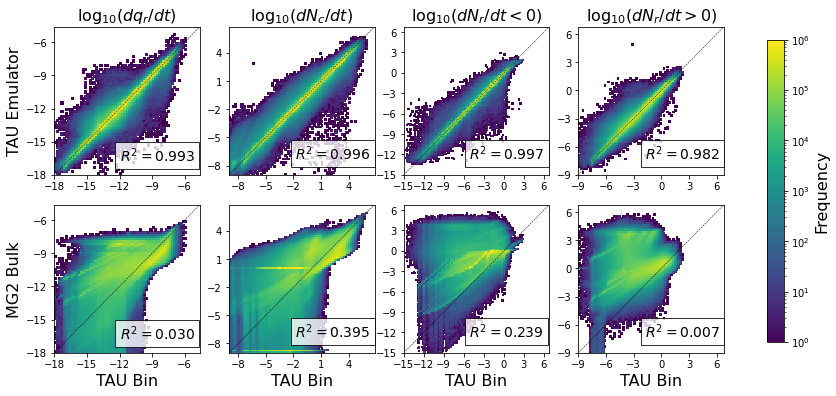

In [5]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
hist2d_ylabels = [f"{source} Emulator", "MG2 Bulk"]
x_labels = ["$\log_{10}(dq_r/dt)$", "$\log_{10}(dN_c/dt)$", 
            "$\log_{10}(dN_r/dt < 0)$", "$\log_{10}(dN_r/dt > 0)$"]
vmax = 1e6
bins = dict(qr=np.arange(-18, -4.5, 0.2),
            nc=np.arange(-9, 7, 0.2),
            nr_neg=np.arange(-15, 7, 0.2),
            nr_pos=np.arange(-9, 7, 0.2))
ticks = dict(qr=np.arange(-18, -4, 3),
             nc=np.arange(-8, 7, 3),
             nr_neg=np.arange(-15, 7, 3),
             nr_pos=np.arange(-9, 7, 3))
h_out = axes[0, 0].hist2d(test_cam_values.loc[test_cam_labels[f"qrtend_{source}"] == 1, f"qrtend_{source}"],
                  test_pred_values.loc[test_cam_labels[f"qrtend_{source}"] == 1, f"qrtend_{source}_1"],
                  bins=bins["qr"], cmin=1, norm=LogNorm(), vmax=vmax, rasterized=True)
cax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
cb = fig.colorbar(h_out[-1], cax=cax)
cb.set_label(label="Frequency", size=16)
_ =axes[0, 1].hist2d(test_cam_values.loc[test_cam_labels[f"nctend_{source}"] == 1, f"nctend_{source}"],
                  test_pred_values.loc[test_cam_labels[f"nctend_{source}"] == 1, f"nctend_{source}_1"],
                  bins=bins["nc"], cmin=1, norm=LogNorm(), vmax=vmax, rasterized=True)
_=axes[0, 2].hist2d(test_cam_values.loc[test_cam_labels[f"nrtend_{source}"] == -1, f"nrtend_{source}"],
                  test_pred_values.loc[test_cam_labels[f"nrtend_{source}"] == -1, f"nrtend_{source}_-1"],
                  bins=bins["nr_neg"], cmin=1, norm=LogNorm(), vmax=vmax, rasterized=True)
_=axes[0, 3].hist2d(test_cam_values.loc[test_cam_labels[f"nrtend_{source}"] == 1, f"nrtend_{source}"],
                  test_pred_values.loc[test_cam_labels[f"nrtend_{source}"] == 1, f"nrtend_{source}_1"],
                  bins=bins["nr_pos"], cmin=1, norm=LogNorm(), vmax=vmax, rasterized=True)
_ = axes[1, 0].hist2d(test_cam_values.loc[test_cam_labels[f"qrtend_{source}"] == 1, f"qrtend_{source}"],
                    mg2_test.loc[test_cam_labels[f"qrtend_{source}"] == 1, "qrtend_MG2"],
                  bins=bins["qr"], cmin=1, norm=LogNorm(), vmax=vmax, rasterized=True)
_ =axes[1, 1].hist2d(test_cam_values.loc[test_cam_labels[f"nctend_{source}"] == 1, f"nctend_{source}"],
                     mg2_test.loc[test_cam_labels[f"nctend_{source}"] == 1, "nctend_MG2"],
                  bins=bins["nc"], cmin=1, norm=LogNorm(), vmax=vmax, rasterized=True)
_=axes[1, 2].hist2d(test_cam_values.loc[test_cam_labels[f"nrtend_{source}"] == -1, f"nrtend_{source}"],
                    mg2_test.loc[test_cam_labels[f"nrtend_{source}"] == -1, "nrtend_MG2"],
                  bins=bins["nr_neg"], cmin=1, norm=LogNorm(), vmax=vmax, rasterized=True)
_=axes[1, 3].hist2d(test_cam_values.loc[test_cam_labels[f"nrtend_{source}"] == 1, f"nrtend_{source}"],
                    mg2_test.loc[test_cam_labels[f"nrtend_{source}"] == 1, "nrtend_MG2"],
                  bins=bins["nr_pos"], cmin=1, norm=LogNorm(), vmax=vmax, rasterized=True)
for a, out in enumerate(["qr", "nc", "nr_neg", "nr_pos"]):
    axes[0, a].plot(bins[out], bins[out], 'k--', lw=0.5)
    axes[1, a].plot(bins[out], bins[out], 'k--', lw=0.5)

for i in range(2):
    for j, out in enumerate(["qr", "nc", "nr_neg", "nr_pos"]):
        axes[i, j].set_xticks(ticks[out])
        axes[i, j].set_yticks(ticks[out])

    axes[i, 0].set_ylabel(hist2d_ylabels[i], fontsize=16)
for j, out in enumerate(["qr", "nc", "nr_neg", "nr_pos"]):
    axes[1, j].set_xlabel(f"{source}_noL2 Bin", fontsize=16)
    axes[0, j].set_title(x_labels[j], fontsize=16)
    axes[0, j].text(bins[out][int(bins[out].size * 0.45)], 
                    bins[out][int(bins[out].size * 0.1)], f"$R^2=${reg_scores.iloc[j, 2]:0.3f}", fontsize=14, bbox=dict(facecolor='white', alpha=0.8))
    axes[1, j].text(bins[out][int(bins[out].size * 0.45)], 
                    bins[out][int(bins[out].size * 0.1)], f"$R^2=${mg2_scores.iloc[j, 2]:0.3f}", fontsize=14, bbox=dict(facecolor='white', alpha=0.8))

plt.savefig(f"{source}_noL2/tendency_hist2d.pdf", bbox_inches="tight")

# Figure 3
Pre-calculate the histograms for each tendency.

In [6]:
bins = dict(qr=np.arange(-18, -4.5, 0.5),
            nc=np.arange(-8, 7, 0.5),
            nr_neg=np.arange(-15, 7, 0.5),
            nr_pos=np.arange(-9, 7, 0.5))
hists = {}
out_types = ["qr", "nc", "nr_neg", "nr_pos"]
pred_types = ["em", "tau", "mg2"]
col_ext = dict(em=f"{source}_1", tau=f"{source}", mg2="MG2")
pred_dict = dict(em=test_pred_values, tau=test_cam_values, mg2=mg2_test)
for o in out_types:
    hists[o] = {}
    if o == "nr_neg":
        indices = test_cam_labels[f"nrtend_{source}"] == -1
    else:
        indices = test_cam_labels[o[:2] + f"tend_{source}"] == 1
    for ptype in pred_types:
        print(o, ptype)
        if o == "nr_neg" and ptype == "em":
            end_label = f"tend_{source}_-1"
        else:
            end_label = "tend_" + col_ext[ptype]
        hists[o][ptype], _ = np.histogram(pred_dict[ptype].loc[indices, o[:2] + end_label], bins[o], density=True)

qr em
qr tau
qr mg2
nc em
nc tau
nc mg2
nr_neg em
nr_neg tau
nr_neg mg2
nr_pos em
nr_pos tau
nr_pos mg2


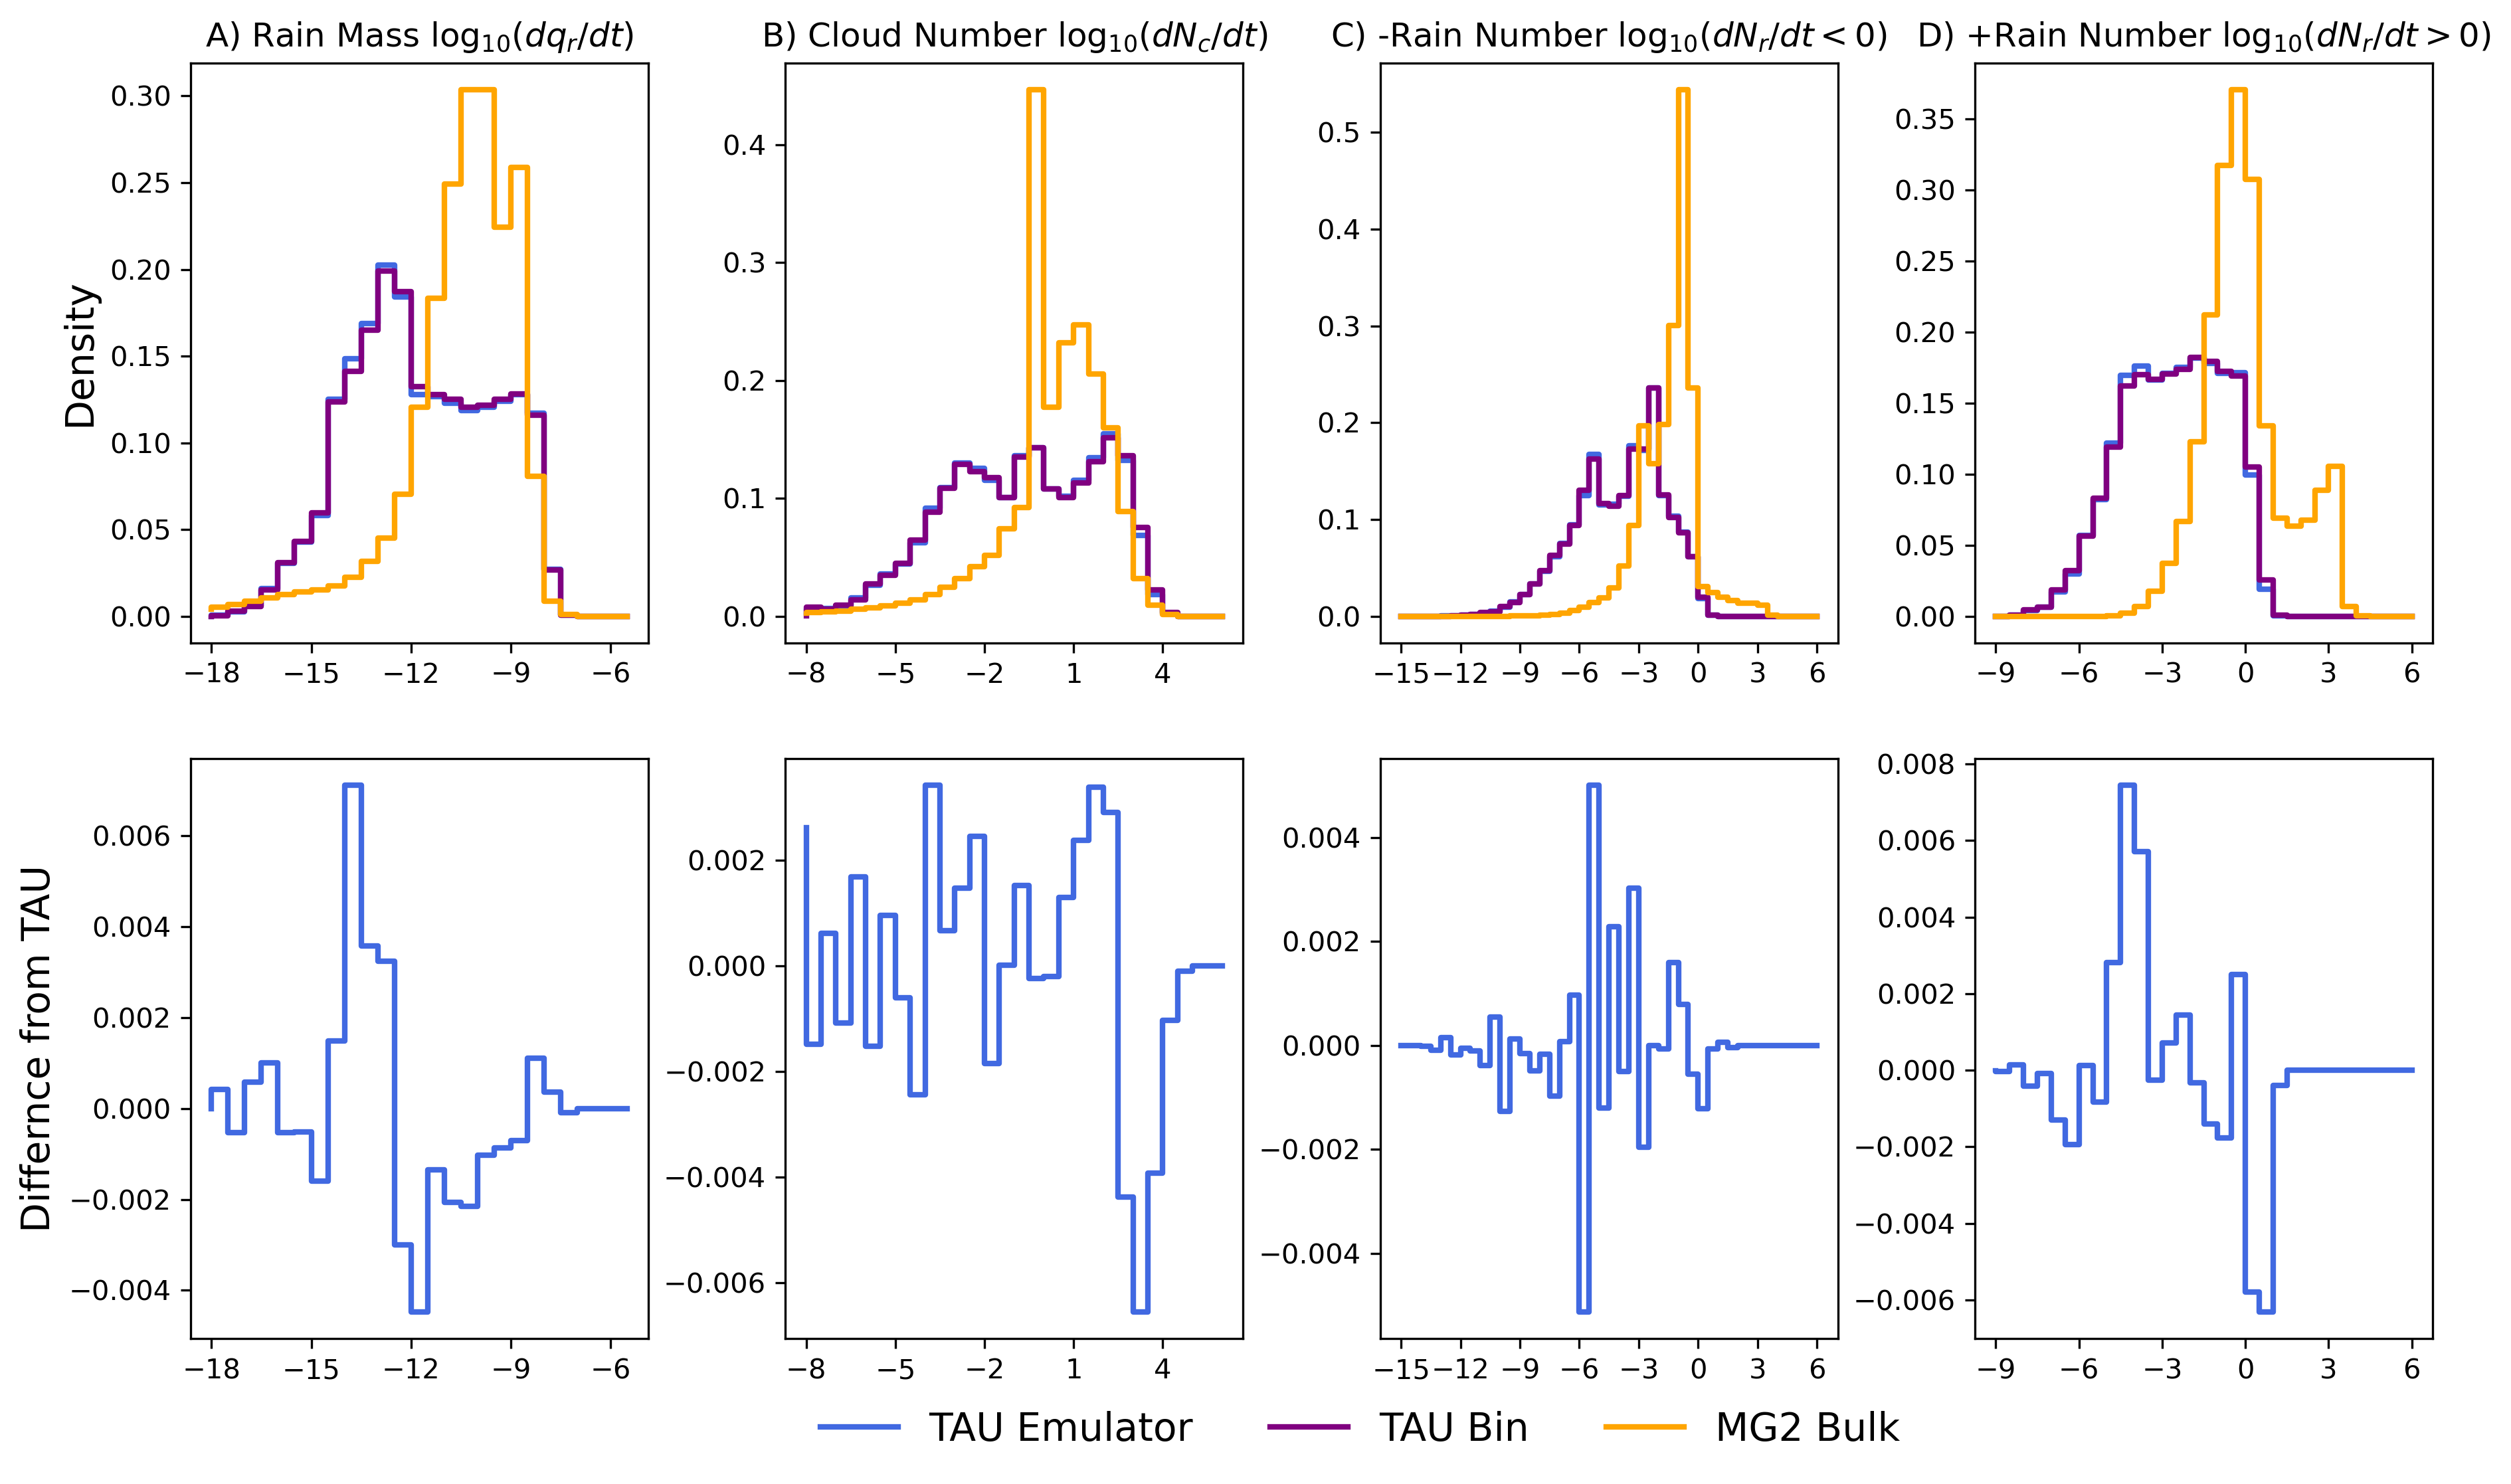

In [7]:
fig, axes = plt.subplots(2, 4, figsize=(12.5, 8), dpi=300, sharey=False)
plt.subplots_adjust(0.05, 0.15, 0.95, 0.95, wspace=0.3)

ticks = dict(qr=np.arange(-18, -4, 3),
             nc=np.arange(-8, 7, 3),
             nr_neg=np.arange(-15, 7, 3),
             nr_pos=np.arange(-9, 7, 3))
y_labels = [f"{source} Emulator", f"{source} Bin", "MG2 Bulk"]
x_labels = ["$\log_{10}(dq_r/dt)$", "$\log_{10}(dN_c/dt)$", 
            "$\log_{10}(dN_r/dt < 0)$", "$\log_{10}(dN_r/dt > 0)$"]
colors = {"em": "royalblue", "tau": "purple", "mg2": "orange"}
plot_objs = []
for a, ax in enumerate(axes[0]):
    o = out_types[a]
    for p in pred_types:
        plot_objs.extend(ax.step(bins[o][:-1], hists[o][p], lw=2, color=colors[p]))
         
for a, ax in enumerate(axes[1]):
    o = out_types[a]
    for p in ["em"]:
        ax.step(bins[o][:-1], hists[o][p] - hists[o][f"tau"], lw=2, color=colors[p])
for j, out in enumerate(["qr", "nc", "nr_neg", "nr_pos"]):
    axes[0, j].set_xticks(ticks[out])
    axes[1, j].set_xticks(ticks[out])
axes[0, 0].set_ylabel("Density", fontsize=14)
axes[1, 0].set_ylabel(f"Differnce from {source}", fontsize=14)
letters = ["A) Rain Mass ", "B) Cloud Number ", "C) -Rain Number ", "D) +Rain Number "]
for j in range(4):
    axes[0, j].set_title(letters[j] + x_labels[j], fontsize=12)
axes[1, 1].legend(plot_objs[:3], y_labels, loc='lower left', bbox_to_anchor=(0, -0.25), ncol=3, fontsize=14, frameon=False)
plt.savefig(f"{source}_noL2/tendency_hist_diff_em_only.pdf", bbox_inches="tight")

# Table 3
Code to generate residual summary values for table 3.

In [8]:
bins_err = np.arange(-10, 10, 0.01)
error_hists = {}
residuals = {}
out_types = ["qr", "nc", "nr_neg", "nr_pos"]
pred_types = ["em", f"{source}", "mg2"]
col_ext = dict(em=f"{source}_1", tau=f"{source}", mg2="MG2")
pred_dict = dict(em=test_pred_values, tau=test_cam_values, mg2=mg2_test)
for o in out_types:
    print(o)
    error_hists[o] = {}
    if o == "nr_neg":
        indices = test_cam_labels[f"nrtend_{source}"] == -1
    else:
        indices = test_cam_labels[o[:2] + f"tend_{source}"] == 1
    if o == "nr_neg":
        end_label = f"tend_{source}_-1"
    else:
        end_label = "tend_" + col_ext["em"]
    end_label_true = "tend_" + col_ext["tau"]
    residuals[o] = pred_dict["em"].loc[indices, o[:2] + end_label] - pred_dict[f"tau"].loc[indices, o[:2] + end_label_true]
    error_hists[o], _ = np.histogram(residuals[o], 
                                     bins_err, density=False)

qr
nc
nr_neg
nr_pos


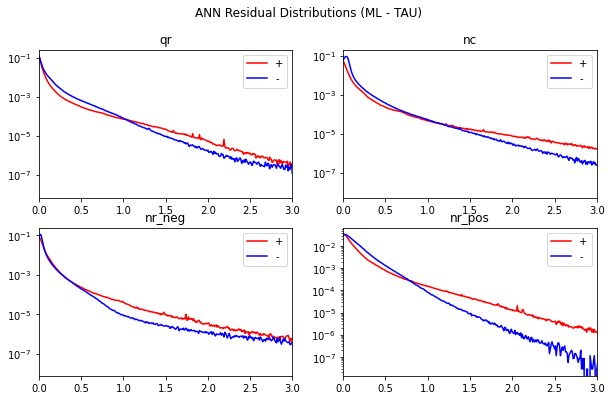

In [9]:
plt.figure(figsize=(10, 6))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(bins_err[bins_err>0][:-1], error_hists[out_types[i]][bins_err[:-1] >= 0] / np.sum(error_hists[out_types[i]]), color="r", label="+")
    plt.plot(-bins_err[bins_err<0], error_hists[out_types[i]][bins_err[:-1] < 0] / np.sum(error_hists[out_types[i]]), color="b", label="-")
    plt.xlim(0, 3)
    plt.legend()
    plt.title(out_types[i])
    plt.gca().set_yscale("log")
plt.suptitle(f"ANN Residual Distributions (ML - {source})")
plt.savefig(f"{source}_noL2/ann_residual_dist.png", dpi=200, bbox_inches="tight")

In [10]:
err_mag = pd.DataFrame(0, index=out_types, columns=[-10, -2, 2, 10])
b_values = [-1, -0.3, 0, 0.3, 1]
for o in out_types:
    for b in range(len(b_values)-1):
        err_mag.loc[o, err_mag.columns[b]] = np.count_nonzero((residuals[o] >= b_values[b]) & (residuals[o] < b_values[b + 1])) / residuals[o].size


In [11]:
err_mag

,-10,-2,2,10
qr,0.034255,0.466287,0.476980,0.017833
nc,0.020881,0.674845,0.285884,0.014133
nr_neg,0.010933,0.512593,0.460411,0.014196
nr_pos,0.072164,0.502608,0.370514,0.046564


In [12]:
err_mag.to_csv("ml_tau_residual_factors.csv", index_label="tendency")


# False Positive and False Negative Grids

In [13]:
time_hours = np.round(meta_test["time"].unique() * 24).astype(int)
print(time_hours.size)
all_time_hours = np.round(meta_test["time"] * 24).astype(int)
fp_grid = np.zeros((32, 192, 288), dtype=int)
fn_grid = np.zeros((32, 192, 288), dtype=int)

fp = (test_pred_labels[f"qrtend_{source}"] == 1) & (test_cam_labels[f"qrtend_{source}"] == 0)
fn = (test_pred_labels[f"qrtend_{source}"] == 0) & (test_cam_labels[f"qrtend_{source}"] == 1)
for th in time_hours:
    print(th)
    tfp =  (all_time_hours == th) & (fp)
    tfn =  (all_time_hours == th) & (fn)
    fp_grid[meta_test.loc[tfp, "depth"], meta_test.loc[tfp,"row"], meta_test.loc[tfp, "col"]] += 1
    fn_grid[meta_test.loc[tfn, "depth"], meta_test.loc[tfn,"row"], meta_test.loc[tfn, "col"]] += 1

344
8875
8900
8925
8950
8975
9000
9025
9050
9075
9100
9125
9150
9175
9200
9225
9250
9275
9300
9325
9350
9375
9400
9425
9450
9475
9500
9525
9550
9575
9600
9625
9650
9675
9700
9725
9750
9775
9800
9825
9850
9875
9900
9925
9950
9975
10000
10025
10050
10075
10100
10125
10150
10175
10200
10225
10250
10275
10300
10325
10350
10375
10400
10425
10450
10475
10500
10525
10550
10575
10600
10625
10650
10675
10700
10725
10750
10775
10800
10825
10850
10875
10900
10925
10950
10975
11000
11025
11050
11075
11100
11125
11150
11175
11200
11225
11250
11275
11300
11325
11350
11375
11400
11425
11450
11475
11500
11525
11550
11575
11600
11625
11650
11675
11700
11725
11750
11775
11800
11825
11850
11875
11900
11925
11950
11975
12000
12025
12050
12075
12100
12125
12150
12175
12200
12225
12250
12275
12300
12325
12350
12375
12400
12425
12450
12475
12500
12525
12550
12575
12600
12625
12650
12675
12700
12725
12750
12775
12800
12825
12850
12875
12900
12925
12950
12975
13000
13025
13050
13075
13100
13125
13150
13175
132

In [14]:
import xarray as xr
cam_path = "/glade/p/cisl/aiml/dgagne/SD_long_2000_50"
ds_cam = xr.open_mfdataset(join(cam_path, "SD_long_2000_50.cam.h0.*.nc"))

/glade/work/ggantos/ncar_20200417/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  This is separate from the ipykernel package so we can avoid doing imports until
/glade/work/ggantos/ncar_20200417/lib/python3.6/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


In [15]:
np.arange(32)[-12:].size


12

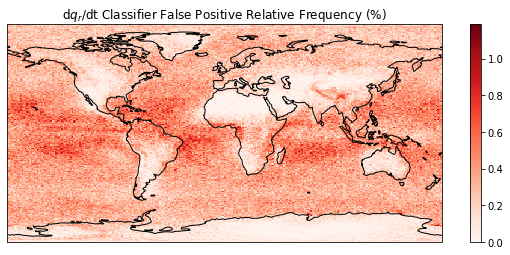

In [16]:
plt.figure(figsize=(10, 4))
ax = plt.axes(projection=ccrs.PlateCarree())
plt.pcolormesh(ds_cam["lon"], ds_cam["lat"], fp_grid[-12:].sum(axis=0) / (344 * 12) * 100, cmap="Reds")
plt.colorbar()
ax.coastlines()
ax.set_title("d$q_r$/dt Classifier False Positive Relative Frequency (%)")
plt.savefig(f"{source}_noL2/qr_classifier_fp_map.png", dpi=200, bbox_inches="tight")

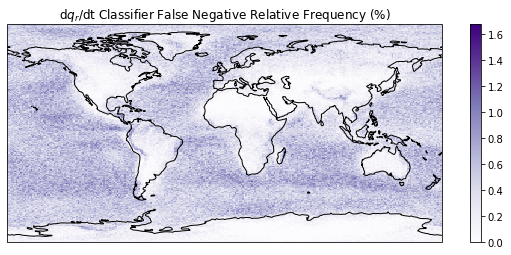

In [17]:
plt.figure(figsize=(10, 4))
ax = plt.axes(projection=ccrs.PlateCarree())
plt.pcolormesh(ds_cam["lon"], ds_cam["lat"], fn_grid[-12:].sum(axis=0) / (344 * 12) * 100, cmap="Purples")
plt.colorbar()
ax.coastlines()
ax.set_title("d$q_r$/dt Classifier False Negative Relative Frequency (%)")
plt.savefig(f"{source}_noL2/qr_classifier_fn_map.png", dpi=200, bbox_inches="tight")

# Old version of Histogram Code

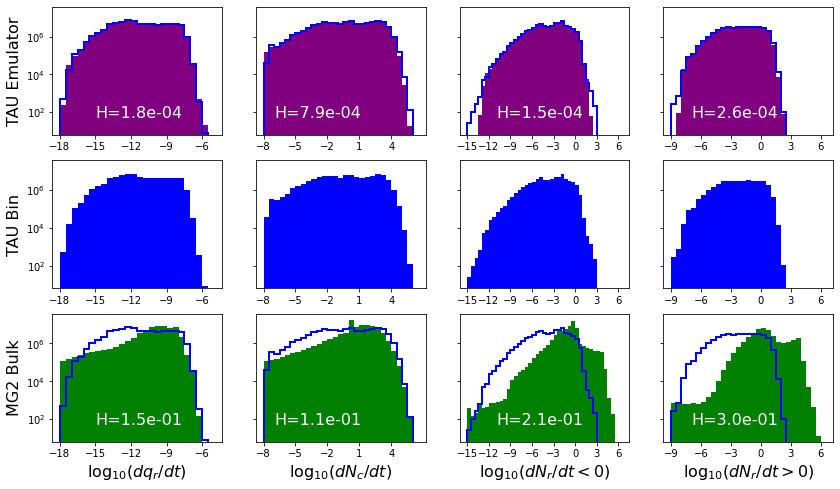

In [18]:
fig, axes = plt.subplots(3, 4, figsize=(14, 8), sharey=True)
bins = dict(qr=np.arange(-18, -4.5, 0.5),
            nc=np.arange(-8, 7, 0.5),
            nr_neg=np.arange(-15, 7, 0.5),
            nr_pos=np.arange(-9, 7, 0.5))
ticks = dict(qr=np.arange(-18, -4, 3),
             nc=np.arange(-8, 7, 3),
             nr_neg=np.arange(-15, 7, 3),
             nr_pos=np.arange(-9, 7, 3))
y_labels = [f"{source} Emulator", f"{source} Bin", "MG2 Bulk"]
x_labels = ["$\log_{10}(dq_r/dt)$", "$\log_{10}(dN_c/dt)$", 
            "$\log_{10}(dN_r/dt < 0)$", "$\log_{10}(dN_r/dt > 0)$"]
axes[0, 0].hist(test_pred_values.loc[test_cam_labels[f"qrtend_{source}"] == 1, f"qrtend_{source}_1"], bins=bins["qr"], color="purple")
axes[1, 0].hist(test_cam_values.loc[test_cam_labels[f"qrtend_{source}"] == 1, f"qrtend_{source}"], bins=bins["qr"], color="blue")
axes[2, 0].hist(mg2_test.loc[test_cam_labels[f"qrtend_{source}"] == 1, "qrtend_MG2"], 
                bins=bins["qr"], color="green")
axes[0, 0].hist(test_cam_values.loc[test_cam_labels[f"qrtend_{source}"] == 1, f"qrtend_{source}"], 
                bins=bins["qr"], color="blue", histtype="step", lw=2)
axes[2, 0].hist(test_cam_values.loc[test_cam_labels[f"qrtend_{source}"] == 1, f"qrtend_{source}"], 
                bins=bins["qr"], color="blue", histtype="step", lw=2)

axes[0, 0].set_yscale("log")
axes[0, 1].hist(test_pred_values.loc[test_cam_labels[f"nctend_{source}"] == 1, f"nctend_{source}_1"], bins=bins["nc"], color="purple")
axes[1, 1].hist(test_cam_values.loc[test_cam_labels[f"nctend_{source}"] == 1, f"nctend_{source}"], bins=bins["nc"], color="blue")
axes[2, 1].hist(mg2_test.loc[test_cam_labels[f"nctend_{source}"] == 1, "nctend_MG2"], 
                bins=bins["nc"], color="green")
axes[0, 1].hist(test_cam_values.loc[test_cam_labels[f"nctend_{source}"] == 1, f"nctend_{source}"], 
                bins=bins["nc"], color="blue", histtype="step", lw=2)
axes[2, 1].hist(test_cam_values.loc[test_cam_labels[f"nctend_{source}"] == 1, f"nctend_{source}"], 
                bins=bins["nc"], color="blue", histtype="step", lw=2)

axes[0, 2].hist(test_pred_values.loc[test_cam_labels[f"nrtend_{source}"] == -1, f"nrtend_{source}_-1"], bins=bins["nr_neg"], color="purple")
axes[1, 2].hist(test_cam_values.loc[test_cam_labels[f"nrtend_{source}"] == -1, f"nrtend_{source}"], bins=bins["nr_neg"], color="blue")
axes[2, 2].hist(mg2_test.loc[test_cam_labels[f"nrtend_{source}"] == -1, "nrtend_MG2"], 
                bins=bins["nr_neg"], color="green")
axes[0, 2].hist(test_cam_values.loc[test_cam_labels[f"nrtend_{source}"] == -1, f"nrtend_{source}"], 
                bins=bins["nr_neg"], color="blue", histtype="step", lw=2)
axes[2, 2].hist(test_cam_values.loc[test_cam_labels[f"nrtend_{source}"] == -1, f"nrtend_{source}"], 
                bins=bins["nr_neg"], color="blue", histtype="step", lw=2)


axes[0, 3].hist(test_pred_values.loc[test_cam_labels[f"nrtend_{source}"] == 1, f"nrtend_{source}_1"], bins=bins["nr_pos"], color="purple")
axes[1, 3].hist(test_cam_values.loc[test_cam_labels[f"nrtend_{source}"] == 1, f"nrtend_{source}"], bins=bins["nr_pos"], color="blue")
axes[2, 3].hist(mg2_test.loc[test_cam_labels[f"nrtend_{source}"] == 1, "nrtend_MG2"], 
                bins=bins["nr_pos"], color="green")
axes[0, 3].hist(test_cam_values.loc[test_cam_labels[f"nrtend_{source}"] == 1, f"nrtend_{source}"], 
                bins=bins["nr_pos"], color="blue", histtype="step", lw=2)
axes[2, 3].hist(test_cam_values.loc[test_cam_labels[f"nrtend_{source}"] == 1, f"nrtend_{source}"], 
                bins=bins["nr_pos"], color="blue", histtype="step", lw=2)

for i in range(3):
    for j, out in enumerate(["qr", "nc", "nr_neg", "nr_pos"]):
        axes[i, j].set_xticks(ticks[out])
    axes[i, 0].set_ylabel(y_labels[i], fontsize=16)
x_pos = [-15, -7, -11, -7]
for j in range(4):
    axes[0, j].text(x_pos[j], 50, f"H={reg_scores.iloc[j, 3]:1.1e}", fontsize=16, color='w')
    axes[2, j].text(x_pos[j], 50, f"H={mg2_scores.iloc[j, 3]:1.1e}", fontsize=16, color='w')

    axes[2, j].set_xlabel(x_labels[j], fontsize=16)
plt.savefig(f"{source}_noL2/tendency_hist.pdf", bbox_inches="tight")
